# RSSI Indoor localisation dataset generator

This is an example code to synthetically generate RSSI data for indoor localisation in random house settings. The parameters that can be controlled are the following:

- n_rooms: Number of rooms.
- largest_distance: Largest distance between any pair of rooms (in units).
- room_size: Width and lenght per room
- n_locations: Number of visited locations per room (eg. 5 locations in each room)
- n_sensors: Number of RSSI receiver sensors

- sensor_locations: List of room names indicating the existence of a sensor in corner (0,0)
- room_names: List of room names in the house

The RSSI values are computed given the X,Y positions in each room, the distance between rooms, the position of the receiver sensors, and random noise per sensor using the following path loss model [1]

$$RSS = -10n\log(D) + C$$

where:

- D: Is the euclidean distance from the sensor to the x,y position
- n: Is the loss of the environment
- C: Is a constant sensor intrinsic loss

```
[1] P. Kumar, L. Reddy, and S. Varma, “Distance measurement and error estimation scheme for RSSI based localization in wireless sensor networks,” in 5th International Conference on Wireless Communication and Sensor Networks, WCSN-2009, 2009, pp. 80–83.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from housegenerator.generator import RandomHouse

def draw_matrix(m, labels, title=None):
    fig, ax = plt.subplots()
    ax.set_title(title)
    im = ax.imshow(m, cmap='viridis')
    if len(np.unique(m)) > 2:
        fig.colorbar(im)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels, rotation=45, ha='right')
    ax.set_ylim(len(labels)-0.5, -0.5)
    
from matplotlib.patches import Rectangle
from matplotlib import cm
def plot_room_walkaround(locations, room_size, title=None, sensor=False, lines=True, dots=True):
    if not lines and not dots:
        return
    n_locations = locations.shape[0]
    fig, ax = plt.subplots()
    ax.set_title(title)
    cmap = cm.get_cmap('Blues')

    rect = Rectangle((0, 0), room_size[0], room_size[1],linewidth=1, edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    if dots:
        ax.scatter(locations[:,0], locations[:,1], color=cmap(np.linspace(0.01, 1, n_locations)))
    if lines:
        ax.plot(locations[:,0], locations[:,1], alpha=0.5)
    ax.set_xlim((-0.5, max(room_size)+0.5))
    ax.set_ylim((-0.5, max(room_size)+0.5))
    if sensor:
        ax.scatter(0, 0, 100, c='red', marker='*')

# Random rooms and distances

We first define the number of rooms and largest distance between rooms, this code randomly generates these distances and rooms

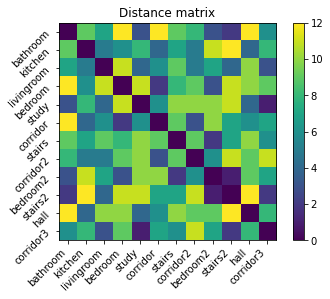

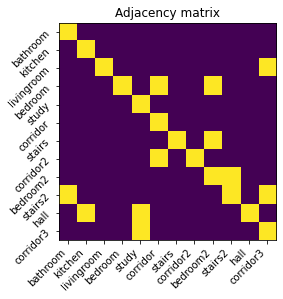

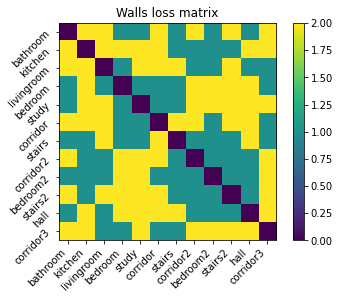

In [2]:
house = RandomHouse(random_seed=2)
    
draw_matrix(house.distance_m, house.room_names, title='Distance matrix')
draw_matrix(house.adjacency_m, house.room_names, title='Adjacency matrix')
draw_matrix(house.walls_loss_m, house.room_names, title='Walls loss matrix')

# Distances graph

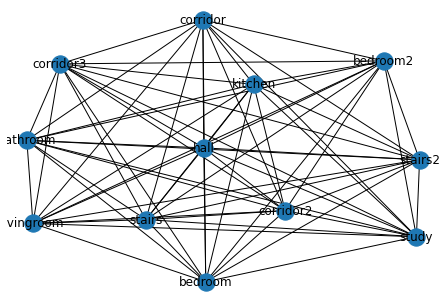

In [3]:
import networkx as nx

graph = nx.from_numpy_matrix(house.distance_m)
graph = nx.relabel.relabel_nodes(graph, {i:name for i, name in enumerate(house.room_names)})
pos=nx.spring_layout(graph)
nx.draw(graph, pos)
labels = nx.draw_networkx_labels(graph, pos)

# Adjacency graph

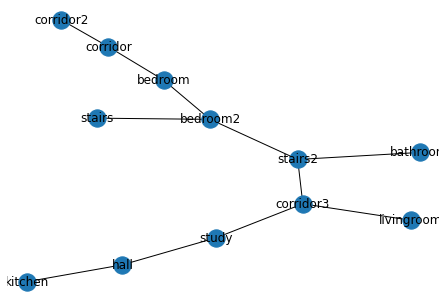

In [4]:
G = nx.from_numpy_matrix(house.adjacency_m)
G = nx.relabel.relabel_nodes(G, {i:name for i, name in enumerate(house.room_names)})
pos=nx.spring_layout(G)
nx.draw(G, pos)
labels = nx.draw_networkx_labels(G, pos)

# Simulate walkaround per room

Here we simulate a walkaround for each room of the synthetic house. And add receiver sensors in a number of rooms, indicated with a red star in the room's cohordinates (0, 0).

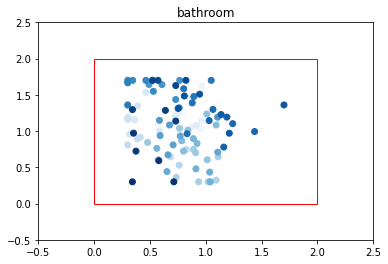

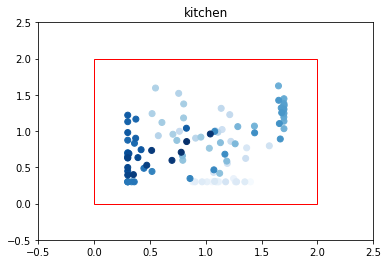

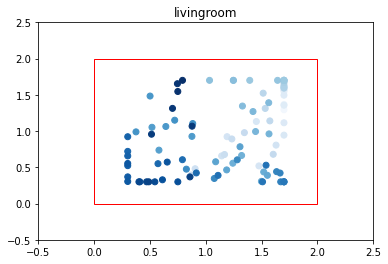

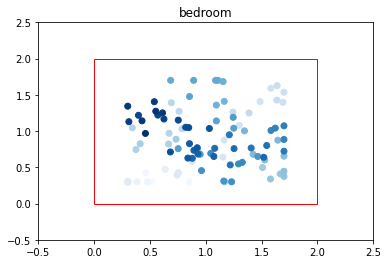

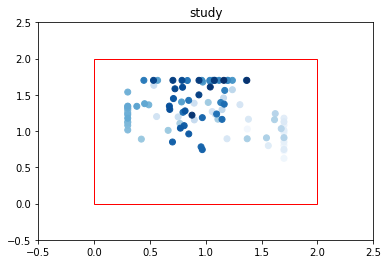

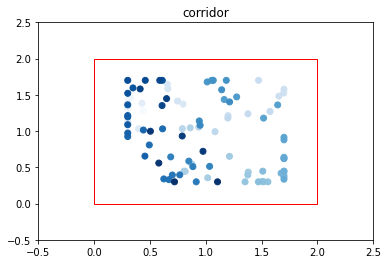

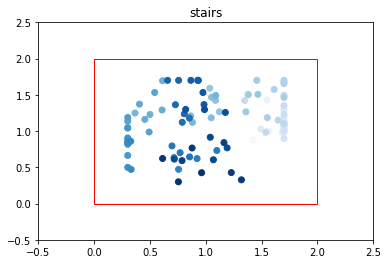

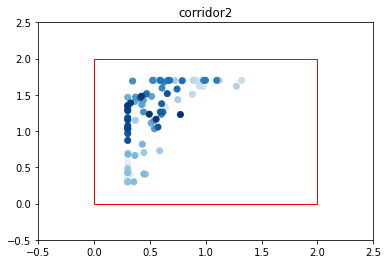

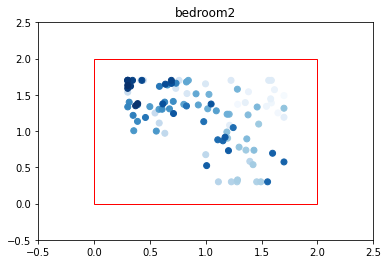

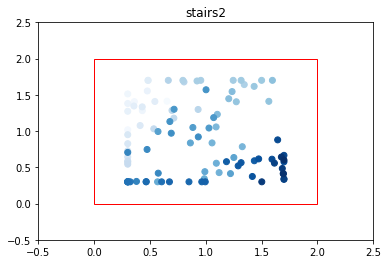

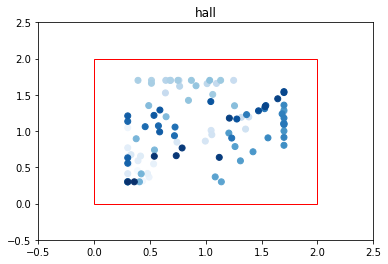

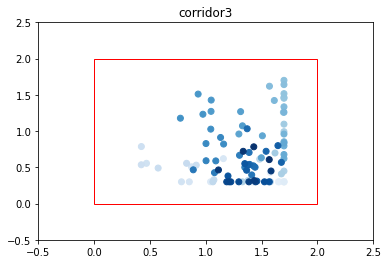

In [5]:
walkaround_dict = house.retrieve_walkaround(number=0, n_locations=10, samples_inbetween=10)

for i, (room_name, walkaround) in enumerate(walkaround_dict.items()):
    plot_room_walkaround(walkaround['path'], house.room_dimensions[i],
                         title=room_name,
                         lines=False)

# Summary of walkarounds

The following figure shows the x and y coordinates with respect to the origin of each room.

Text(0, 0.5, 'Room fine locations')

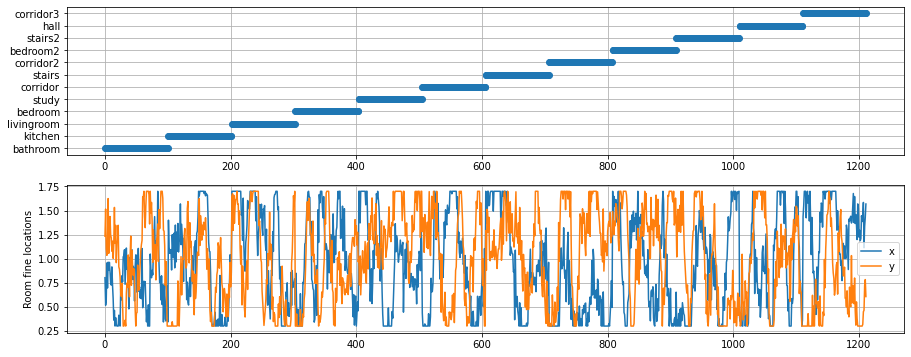

In [6]:
X, y = house.walkaround_as_x_y(0, 'path')

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y, 'o')
ax.grid()
ax.set_yticks(range(house.n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2)
ax.grid()
ax.plot(X)
ax.legend(['x', 'y'])
ax.set_ylabel('Room fine locations')

# Summary euclidean distances to room1

Here we show the euclidean distances to the origin of the first room of the house for all the walkarounds

Text(0, 0.5, 'Eucl. dist. to bathroom')

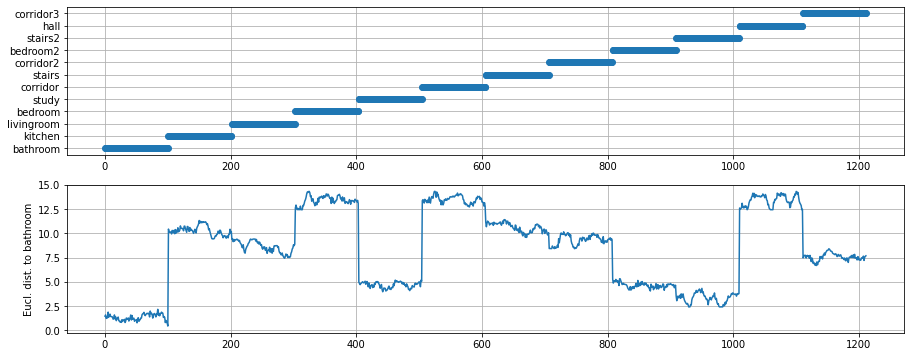

In [7]:
eucl_distances = np.sqrt(np.sum(X**2, axis=1))
eucl_distances += house.distance_m[0][y]

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y, 'o')
ax.grid()
ax.set_yticks(range(house.n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2)
ax.grid()
ax.plot(eucl_distances)
ax.set_ylabel('Eucl. dist. to {}'.format(house.room_names[0]))

# Distances to sensors

Here we show the euclidean distance to each sensor, considering the distances between rooms.

Text(0, 0.5, 'Eucl. distance to sensors')

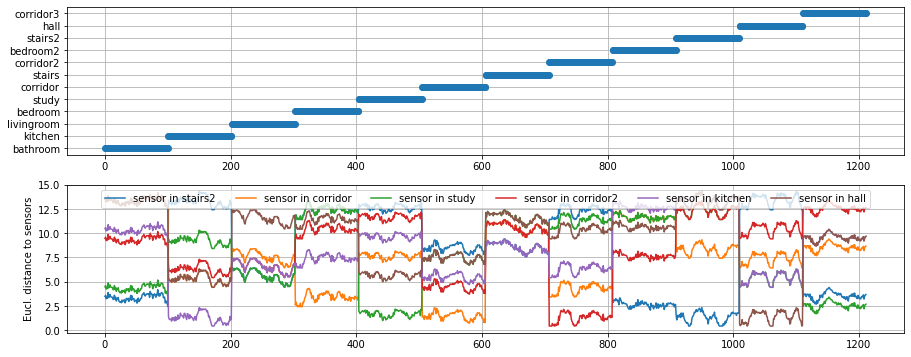

In [8]:
X_dist, y = house.get_sensor_distances(0)

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y, 'o')
ax.grid()
ax.set_yticks(range(house.n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.grid()
ax.plot(X_dist)
ax.legend(['sensor in ' + room for room in house.sensor_locations], loc='upper center', ncol=6)
ax.set_ylabel('Eucl. distance to sensors')

# Path loss model

we apply a path loss model to compute the RSSI signal to each sensor, considering a random constant loss per sensor, as well as a random loss per exact x, y position

Text(0, 0.5, 'RSSI')

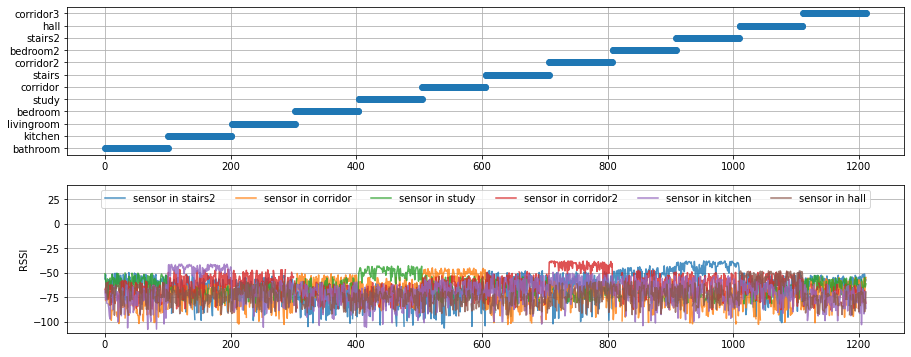

In [9]:
X_rssi, y = house.get_sensor_rssi(0)

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y, 'o')
ax.grid()
ax.set_yticks(range(house.n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.grid()
ax.plot(X_rssi, alpha=0.8)
ax.set_ylim((ax.get_ylim()[0], 40))
ax.legend(['sensor in ' + room for room in house.sensor_locations], loc='upper center', ncol=6)
ax.set_ylabel('RSSI')

# Aggregating RSSI

In order to train a model, we will aggregate the raw RSSI data, as it proves to be very noisy. This is the case in real data as well.

Text(0, 0.5, 'Mean RSSI')

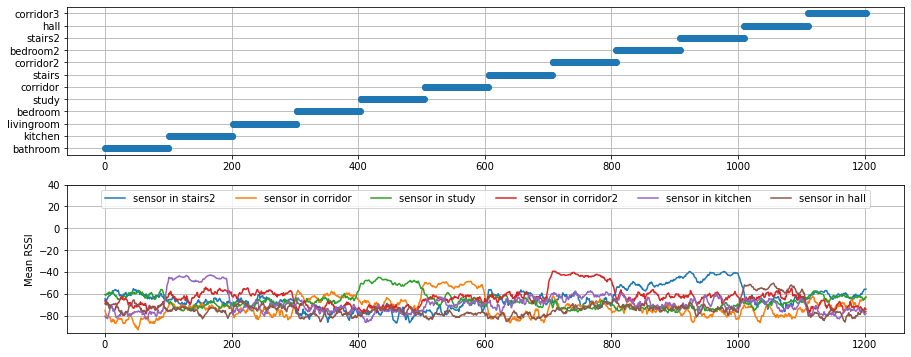

In [10]:
def rolling_window(a, window):
    """Creates a rolling window matrix from an original matrix
    Parameters
    ----------
    a : ndarray
    window : int
        Window size
    Returns
    -------
    matrix : ndarray
        With same shape as the original matrix a with an additional dimension
    """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def get_subsequences(x, y, window=10):
    """
    Parameters
    ----------
    x : ndarray
        Matrix of shape (S,D) where S is the number of samples and D is the
        number of dimensions.
    y : ndarray
        Matrix of shape (S,C) where S is the number of samples and C is the
        number of classes.
    window : integer, optional
        Number of subsequences to obtain.
    Returns
    -------
    x_seq : ndarray
        Matrix of shape (S-window/2,D,window) where the first dimension
        corresponds to a copy of the original matrix swifted one position.
    y_seq : ndarray
        Matrix of shape (S-window/2,D,window) where the first dimension
        corresponds to a copy of the original matrix swifted one position.
    """
    x_seq = rolling_window(x.T, window)
    y_seq = rolling_window(y.T, window)

    x_seq = np.swapaxes(x_seq, 0, 1)
    y_seq = np.swapaxes(y_seq, 0, 1)
    return x_seq, y_seq

X_sub, y_sub = get_subsequences(X_rssi, y, window=10)
X_train = np.nanmean(X_sub, axis=-1)
y_train = y_sub[0,:]

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y_train, 'o')
ax.grid()
ax.set_yticks(range(house.n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.grid()
ax.plot(X_train)
ax.set_ylim((ax.get_ylim()[0], 40))
ax.legend(['sensor in ' + room for room in house.sensor_locations], loc='upper center', ncol=6)
ax.set_ylabel('Mean RSSI')

# Create a second walkaround

/home/miquel/git/uob/RandomHouseGenerator/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


Text(0, 0.5, 'Mean RSSI')

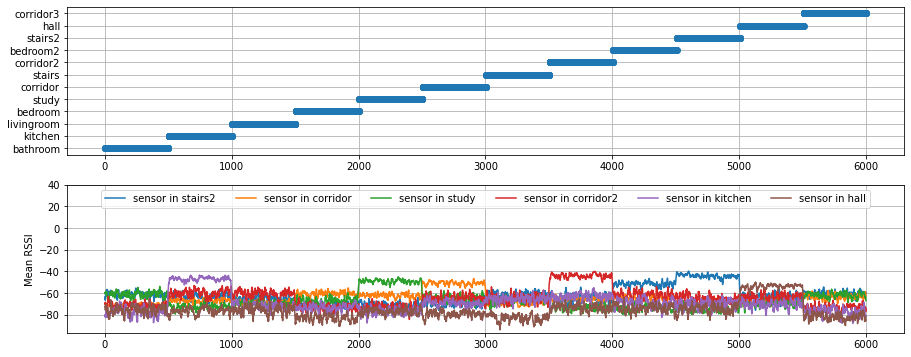

In [11]:
walkaround = house.retrieve_walkaround(number=1, n_locations=50)
X_test, y_test = house.get_sensor_rssi(number=1)
X_test, y_test = get_subsequences(X_test, y_test, window=10)
X_test = np.nanmean(X_test, axis=-1)
y_test = y_test[0,:]

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(y_test, 'o')
ax.grid()
ax.set_yticks(range(house.n_rooms))
ax.set_yticklabels(house.room_names)
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.grid()
ax.plot(X_test)
ax.set_ylim((ax.get_ylim()[0], 40))
ax.legend(['sensor in ' + room for room in house.sensor_locations], loc='upper center', ncol=6)
ax.set_ylabel('Mean RSSI')

# Model training and evaluation

Here we train a model in the aggregated RSSI data, and show the cross-validation performance

/home/miquel/git/uob/RandomHouseGenerator/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/miquel/git/uob/RandomHouseGenerator/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/miquel/git/uob/RandomHouseGenerator/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/miquel/git/uob/RandomHouseGenerator/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/miquel/git/uob/RandomHouseGenerator/venv/lib/p

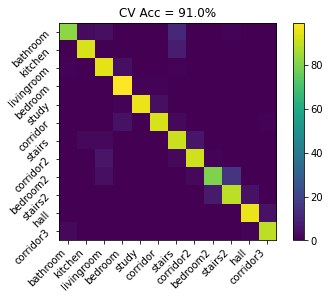

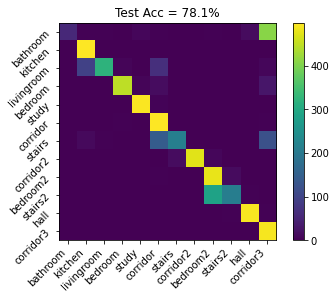

In [12]:
import sys
sys.path.append('../')
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict

cv = StratifiedKFold(n_splits=5, shuffle=False)

drop_proportion = 0.0
clf = RandomForestClassifier(n_estimators=200)
steps = [('imputer', SimpleImputer(missing_values=np.nan,    
                                   strategy='constant',    
                                   fill_value=-120)),    
         ('clf', clf)]
pip_params = {}

pipeline = Pipeline(steps)
grid = GridSearchCV(pipeline, param_grid=pip_params, cv=cv,
                    refit=True, iid=True)

grid.fit(X_train, y_train)
scores = cross_val_score(grid, X_train, y_train, cv=cv)
y_pred = cross_val_predict(grid, X_train, y_train, cv=cv)
cm = confusion_matrix(y_train, y_pred, labels=range(len(house.room_names)))
fig = draw_matrix(cm, house.room_names,
                           title='CV Acc = {:.01f}%'.format(
                               100*cm.diagonal().sum()/cm.sum()))

# Test performance
y_pred = grid.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=range(len(house.room_names)))
acc = 100*cm.diagonal().sum()/cm.sum()
fig = draw_matrix(cm, house.room_names,
                           title='Test Acc = {:.01f}%'.format(acc))